This notebook contains code for evaluating the test cases generated by a language model based on a few metrics:

- compile errors
- number of passed tests
- number of failed tests
- branch coverage
- statement coverage

The `coverage` package is used to calcuate the last 4 stats. We can combine these metrics to get a single representing the effectiveness of the generated test cases.

In [5]:
!pip install coverage

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.1/229.1 kB 4.6 MB/s eta 0:00:00


In [28]:
import subprocess
import re
import json
import os

def split_into_functions(text):
    """Split the text containing multiple functions into individual functions."""
    lines = text.split('\n')
    functions = []
    function = ''
    for line in lines:
        if line.strip().startswith('def '):
            if function.strip().startswith('def '):
                functions.append(function)
            function = line + '\n'
        else:
            function += line + '\n'
    functions.append(function)

    return functions

def check_compile_errors(functions):
    """Check the functions for complie error.
    Also return the functions that can be compiled.
    """
    error_count = 0
    no_error_functions = []

    for function in functions:
        try:
            compile(function, '<string>', 'exec')
            no_error_functions.append(function)
        except SyntaxError:
            error_count += 1

    return error_count, no_error_functions


def ut_eval(program, test_cases, cov_output_file):
    """Evaluate unit test cases.

    Given a program and its test cases, calculate the metrics for unit tests.
    """
    # first get compiler errors
    functions = split_into_functions(test_cases)
    compile_errors, valid_funcs = check_compile_errors(functions)
    metrics = {
        'compile_errors': compile_errors, 'failed': 0, 'passed': 0
    }

    with open('program.py', mode='w') as fout:
      fout.write(program)

    with open('test_cases.py', mode='w') as fout:
      fout.write('from program import *\n')
      fout.writelines(valid_funcs)

    result = subprocess.run(['coverage', 'run', '--branch', '-m', 'pytest', 'test_cases.py'], stdout=subprocess.PIPE)
    output = result.stdout.decode('utf-8')
    matching = re.search(r'(\d+) failed', output)
    if matching:
        metrics['failed'] = int(matching.group(1))
    matching = re.search(r'(\d+) passed', output)
    if matching:
        metrics['passed'] = int(matching.group(1))

    subprocess.run(['coverage', 'json', "--include=program.py", '-o', cov_output_file])
    with open(cov_output_file) as fout:
        cov = json.load(fout)['totals']
        metrics['stm_covered_pct'] = cov['covered_lines']*1.0 / cov['num_statements']
        metrics['branch_covered_pct'] = (cov['covered_branches']*1.0 / cov['num_branches']
                                         if cov['num_branches'] > 0 else 1.0)
        try:
          os.remove(cov_output_file)
        except Exception as ex:
          print(ex)

    return metrics


In [26]:
def batch_ut_eval(data, cov_output_file):
  print('total examples: ', len(data))
  for i, example in enumerate(data):
    print(i, end='\n' if i % 20 == 0 else ' ')
    try:
      metrics = ut_eval(example['output'], example['test_cases'], cov_output_file)
      example.update(metrics)
    except Exception as ex:
      print(ex)


In [1]:
import json
test_cases_file = 'drive/MyDrive/tmp/code_alpaca_with_test_cases.json'

with open(test_cases_file, encoding='utf-8') as fin:
  data = json.load(fin)

In [2]:
data[0]

{'instruction': 'Write a replace method for a string class which replaces the given string with a given set of characters.',
 'input': 'string = "Hello World!"\nreplace_with = "Greetings!"',
 'output': 'def replace(self, replace_with):\n    new_string = ""\n    for char in self:\n        if char == " ":\n            new_string += replace_with\n        else:\n            new_string += char\n    return new_string',
 'test_cases': 'def test_replace_with_empty_string():\n    string = "Hello World!"\n    replace_with = ""\n    assert string.replace(replace_with) == "HelloWorld!"\n\ndef test_replace_with_single_character():\n    string = "Hello World!"\n    replace_with = "A"\n    assert string.replace(replace_with) == "HelloAWorld!"\n\ndef test_replace_with_multiple_characters():\n    string = "Hello World!"\n    replace_with = "XYZ"\n    assert string.replace(replace_with) == "HelloXYZWorld!"\n\ndef test_replace_with_same_string():\n    string = "Hello World!"\n    replace_with = " "\n    

In [30]:
for example in data[0:5]:
  metrics = ut_eval(example['output'], example['test_cases'], 'drive/MyDrive/tmp/cov.json')
  print(metrics)

{'compile_errors': 0, 'failed': 7, 'passed': 0, 'stm_covered_pct': 0.14285714285714285, 'branch_covered_pct': 0.0}
{'compile_errors': 0, 'failed': 0, 'passed': 5, 'stm_covered_pct': 1.0, 'branch_covered_pct': 1.0}
{'compile_errors': 0, 'failed': 2, 'passed': 3, 'stm_covered_pct': 1.0, 'branch_covered_pct': 1.0}
{'compile_errors': 0, 'failed': 1, 'passed': 5, 'stm_covered_pct': 1.0, 'branch_covered_pct': 1.0}
{'compile_errors': 0, 'failed': 0, 'passed': 5, 'stm_covered_pct': 1.0, 'branch_covered_pct': 1.0}


In [31]:
batch_ut_eval(data, 'drive/MyDrive/tmp/cov.json')

total examples:  1702
0
1 2 3 4 5 6 7 8 9 10 11 12 13 14 [Errno 2] No such file or directory: 'drive/MyDrive/tmp/cov.json'
15 16 17 18 19 20
21 22 23 24 25 26 27 28 29 30 31 32 33 [Errno 2] No such file or directory: 'drive/MyDrive/tmp/cov.json'
34 35 36 37 38 39 40
41 42 43 44 45 

KeyboardInterrupt: ignored

In [34]:
data[15]

{'instruction': 'Write an algorithm in Python to determine if a number is even or odd.',
 'input': '',
 'output': 'def is_even(num): \n    if num % 2 == 0: \n        return True \n    else: \n        return False',
 'test_cases': 'def test_is_even_with_even_number():\n    assert is_even(4) == True, "Test failed! Expected output is True"\n\ndef test_is_even_with_odd_number():\n    assert is_even(3) == False, "Test failed! Expected output is False"\n\ndef test_is_even_with_zero():\n    assert is_even(0) == True, "Test failed! Expected output is True"\n\ndef test_is_even_with_negative_even_number():\n    assert is_even(-2) == True, "Test failed! Expected output is True"\n\ndef test_is_even_with_negative_odd_number():\n    assert is_even(-1) == False, "Test failed! Expected output is False"\n',
 'compile_errors': 0,
 'failed': 0,
 'passed': 5,
 'stm_covered_pct': 1.0,
 'branch_covered_pct': 1.0}

In [35]:
import pandas as pd
tmp = pd.DataFrame(data)

<Axes: >

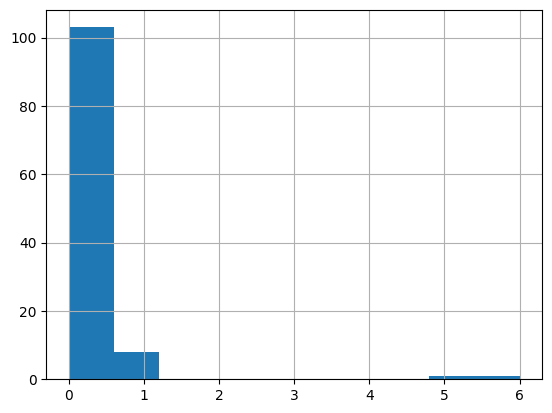

In [45]:
tmp['compile_errors'].hist()

<Axes: >

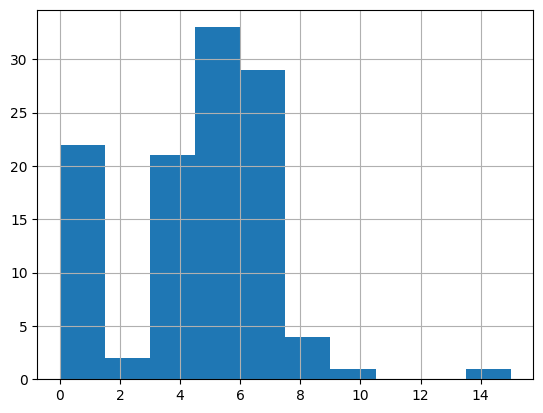

In [46]:
tmp['passed'].hist()

<Axes: >

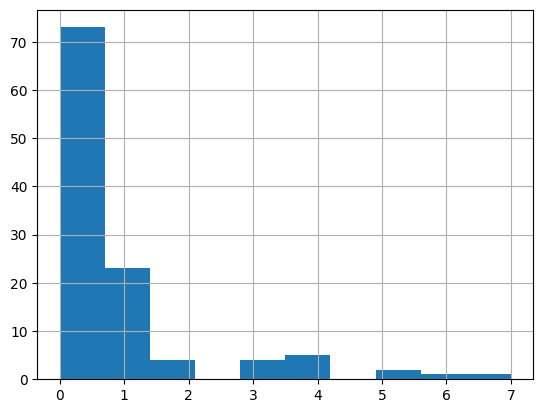

In [47]:
tmp['failed'].hist()